In [1]:
import pandas as pd
import numpy as np
import warnings
import collections
import itertools
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
# import pmdarima as pm #needs IT permission
from pandas.plotting import register_matplotlib_converters
from datetime import date, datetime, time, timedelta
from math import sqrt
from sklearn.model_selection import train_test_split
import pyodbc
import pickle
import sidetable as stb
from pandas.tseries.offsets import MonthEnd
from fbprophet import Prophet


register_matplotlib_converters()


import seaborn as sns
import datetime
import math
from scipy import stats
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.style.use('fivethirtyeight')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%matplotlib inline

In [23]:
df = pd.read_csv('TorontoMeasureData (1).csv')

In [24]:
df.head()

,Measure Name,Year,Period,Value
0,Number of Personal Bankruptcies (Ontario),2007,Jan,2307.0
1,Number of Personal Bankruptcies (Ontario),2007,Feb,2369.0
2,Number of Personal Bankruptcies (Ontario),2007,Mar,2715.0
3,Number of Personal Bankruptcies (Ontario),2007,Apr,2651.0
4,Number of Personal Bankruptcies (Ontario),2007,May,2931.0


In [25]:
df['Measure Name'].unique()

array(['Number of Personal Bankruptcies (Ontario)',
       'Percentage of Ontario Residential Mortgages in Arrears (3 months or more)(%)',
       'Food Bank Usage ',
       'Size of Waiting List for Social Housing (Total Number) ',
       'Number of Rent Bank Loans Granted ',
       'Shelter Use Singles (Average Individual Per Night) ',
       'Shelter Use Families (Average Individuals Per Night) ',
       'Child Care Number of Children on Wait list for a Child Care Fee Subsidy',
       'Crime Total Number of Incidents (in 7 Crime Categories)',
       'Crime Number of Murders ', 'Crime Number of Sexual Assaults ',
       'Crime Number of Assaults ', 'Crime Number of Robberies ',
       'Crime Number of Break and Enters ',
       'Crime Number of Auto Thefts ',
       'Crime Number of Thefts Over $5000 ',
       'Community Planning Number of Applications ',
       'Committee of Adjustment Number of Applications ',
       'Construction Value of Building Permits Issued (All Types)',
     

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7932 entries, 0 to 7931
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Measure Name  7932 non-null   object 
 1   Year          7932 non-null   int64  
 2   Period        7898 non-null   object 
 3   Value         7908 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 248.0+ KB


In [27]:
import calendar
mapper = {v: k for k,v in enumerate(calendar.month_abbr)}


In [28]:
df['Month'] = df['Period'].map(mapper)

Drop measure that have a quarterly frequency and only keep monthly ones

In [29]:
df.dropna(axis=0,subset=['Month'],inplace=True)

In [30]:
df['day'] =1

In [31]:
df['YearMonth'] = pd.to_datetime(df[['Year','Month','day']])

In [36]:
df_1 = df.pivot_table(values='Value', index=df.YearMonth, columns='Measure Name', aggfunc='first')

/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:181: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 



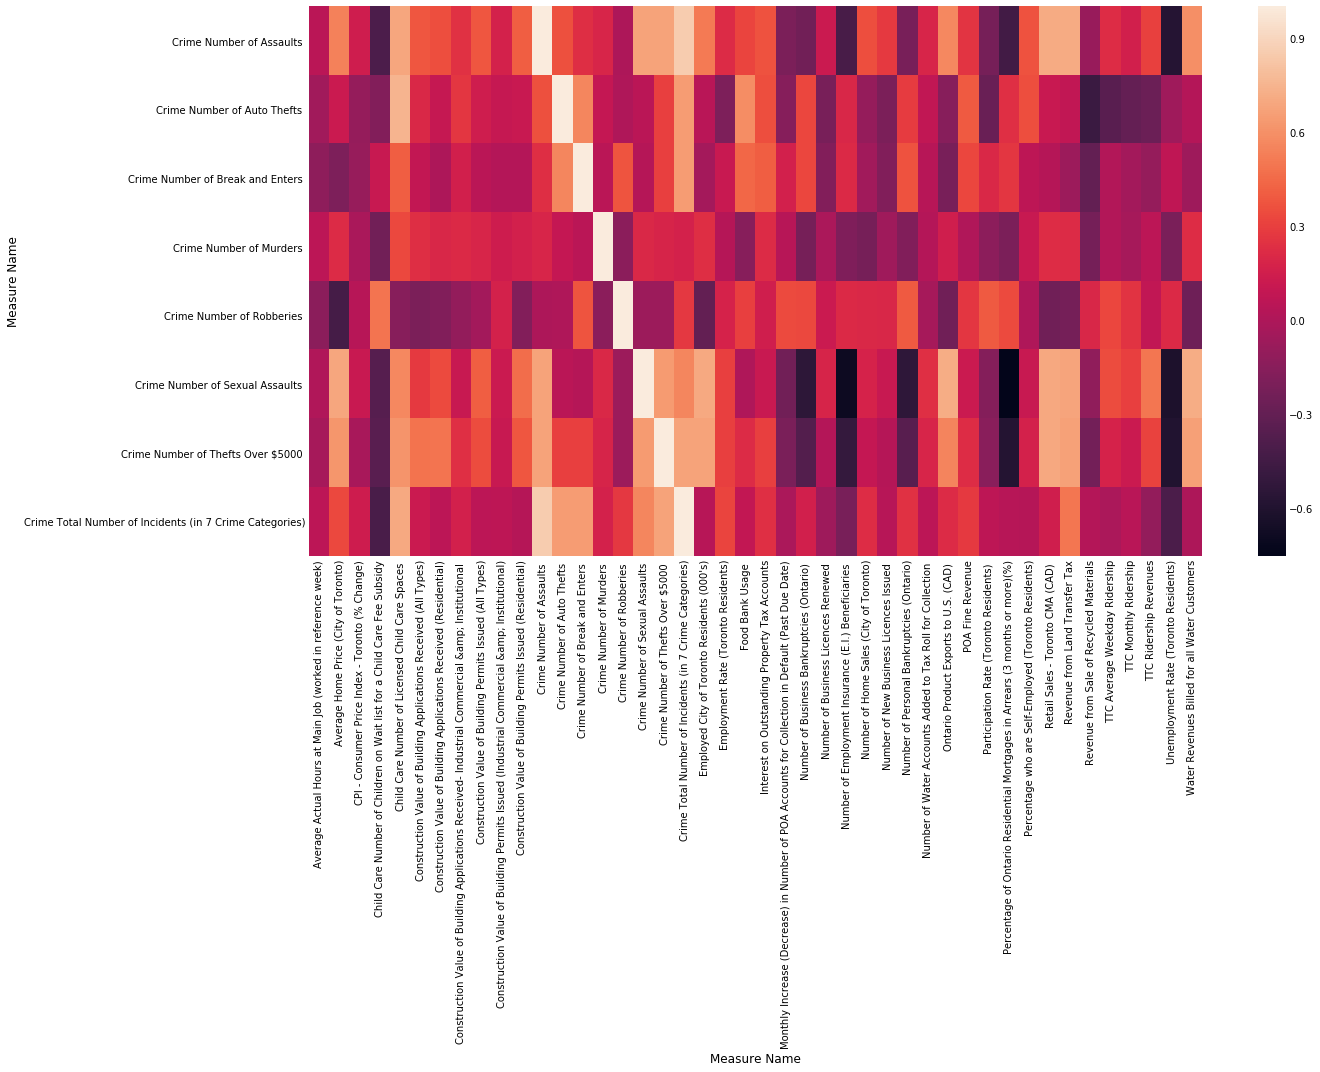

In [43]:
fig,ax = plt.subplots(figsize=(20,15))

sns.heatmap(df_1.corr().iloc[11:19])
plt.tight_layout()
fig.savefig('corrs_crime.png',dpi=200)
plt.tight_layout()

In [52]:
df_relevant = df_1[['Child Care Number of Children on Wait list for a Child Care Fee Subsidy',\
                      'Child Care Number of Licensed Child Care Spaces ','Unemployment Rate (Toronto Residents)',\
                      'Number of Employment Insurance (E.I.) Beneficiaries ',\
                     'Crime Total Number of Incidents (in 7 Crime Categories)']]

Let's start with 
# Using prophet to predict crime (all)

In [62]:
df_test = df_relevant['Crime Total Number of Incidents (in 7 Crime Categories)']
df_test = df_test.reset_index(drop=False).rename({'YearMonth':'ds','Crime Total Number of Incidents (in 7 Crime Categories)':'y'},axis=1)

In [69]:
#starting a simple model

m = Prophet(weekly_seasonality=False,daily_seasonality=False)
m.fit(df_test)


/Applications/anaconda3/lib/python3.6/site-packages/fbprophet/forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.



/Applications/anaconda3/lib/python3.6/site-packages/fbprophet/forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.



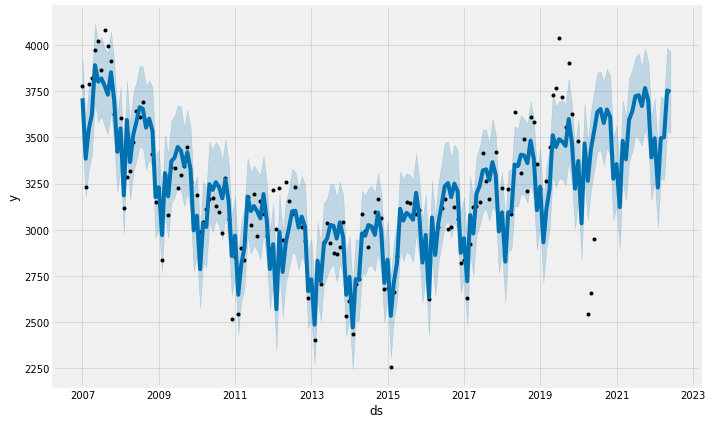

In [71]:
future = m.make_future_dataframe(periods=24,freq='MS')
fcst = m.predict(future)
fig = m.plot(fcst)

In [79]:
df_relevant = df_relevant.reset_index(drop=False).rename({'YearMonth':'ds','Crime Total Number of Incidents (in 7 Crime Categories)':'y'},axis=1)

In [84]:
df_relevant = df_relevant[df_relevant['Number of Employment Insurance (E.I.) Beneficiaries '].notnull()]

In [85]:
#starting a simple model

m = Prophet(weekly_seasonality=False,daily_seasonality=False)

m.add_regressor('Unemployment Rate (Toronto Residents)')
m.add_regressor('Number of Employment Insurance (E.I.) Beneficiaries ')
m.fit(df_relevant)


/Applications/anaconda3/lib/python3.6/site-packages/fbprophet/forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.



In [86]:
future = m.make_future_dataframe(periods=24,freq='MS')
fcst = m.predict(future)
fig = m.plot(fcst)

ValueError: Regressor "Unemployment Rate (Toronto Residents)" missing from dataframe

In [89]:
future

,ds
0,2007-01-01
1,2007-02-01
2,2007-03-01
3,2007-04-01
4,2007-05-01
5,2007-06-01
6,2007-07-01
7,2007-08-01
8,2007-09-01
9,2007-10-01
